In [5]:
import csv
from pathlib import Path
import os

def write_to_csv_parameters(filename):
    fieldnames = ['Date', 'Item Name', 'p', 'd', 'q']
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        writer.writerow(fieldnames)
        
        # writer.writerow([today_date, product_name, p, d, q])
        
base_dir = Path(os.getenv("BASE_DIRECTORY"))
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
write_to_csv_parameters(filename)

         Date Item Name  Low Price  Average Price  High Price
0  12-11-2024     જામફળ        500            850        1200
1  12-11-2024      દાડમ       1000           1700        2400
2  12-11-2024     સફરજન        800           1400        2000
3  12-11-2024    સીતાફળ        500            900        1300
4  12-11-2024      કેળા        400            450         500
['જામફળ' 'દાડમ' 'સફરજન' 'સીતાફળ' 'કેળા' 'સંતરા' 'સ્ટ્રોબેરી' 'ગુલાબ'
 'મોસંબી' 'ટેટી' 'દ્રાક્ષ' 'કીવી' 'આલુચા' 'તરબૂચ' 'ક્મલમ' 'ચીકુ' 'અનાનસ'
 'પોપૈયા' 'માલટા' 'બોર' 'આબલી' 'લિચી' 'કેસર કેરી' 'ઓરેંજ' 'હાફુસ કેરી'
 'લાલબાગ કેરી' 'બદામ કેરી' 'સૂ્દરી કેરી']
Data older than 17-11-2024 has been removed.
જામફળ size:  116
False
Checking stationarity for the raw price data of જામફળ:

ADF Test Results:
ADF Statistic: -7.4567
p-value: 0.0000
Critical Value 1%: -3.4885
Critical Value 5%: -2.8870
Critical Value 10%: -2.5804
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity

<Figure size 1200x600 with 0 Axes>

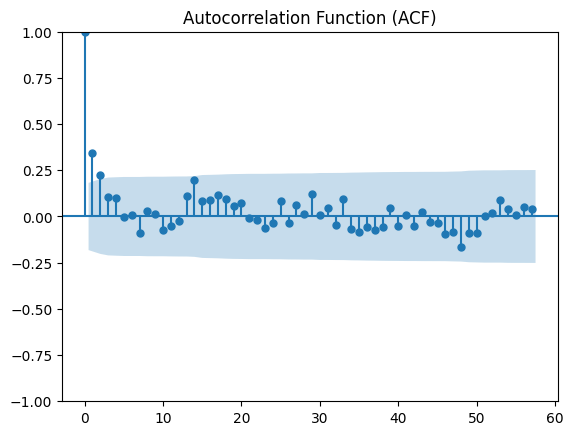

<Figure size 1200x600 with 0 Axes>

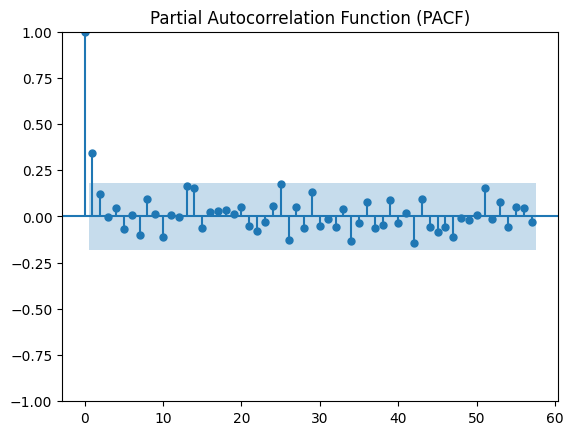


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  116
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -718.843
Date:                Mon, 17 Mar 2025   AIC                           1445.686
Time:                        15:48:42   BIC                           1456.700
Sample:                             0   HQIC                          1450.157
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        716.1208     19.618     36.504      0.000     677.671     754.571
ar.L1          0.3040      0.08

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Updated જામફળ with new (p, d, q): (2, 0, 0)
Model for જામફળ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_1504c4369bfb4acd29b2e036ed2ec032.pkl
દાડમ size:  118
True
Checking stationarity for the raw price data of દાડમ:

ADF Test Results:
ADF Statistic: -8.6781
p-value: 0.0000
Critical Value 1%: -3.4875
Critical Value 5%: -2.8866
Critical Value 10%: -2.5801
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.6781
p-value: 0.0000
Critical Value 1%: -3.4875
Critical Value 5%: -2.8866
Critical Value 10%: -2.5801
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 1 at lags [15]
Significant spikes in PACF (p): 4 at lags [14 15 16 20]


<Figure size 1200x600 with 0 Axes>

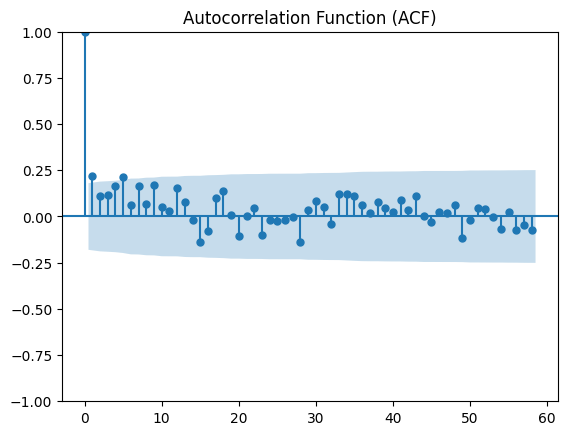

<Figure size 1200x600 with 0 Axes>

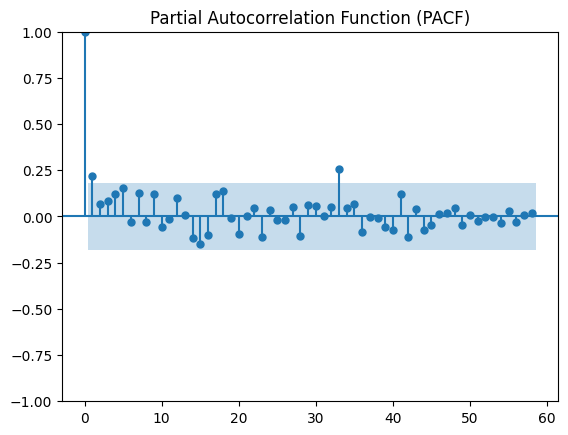


Fitting ARIMA model with order (4, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  118
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -837.596
Date:                Mon, 17 Mar 2025   AIC                           1689.192
Time:                        15:48:44   BIC                           1708.587
Sample:                             0   HQIC                          1697.067
                                - 118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1160.5063    127.490      9.103      0.000     910.631    1410.381
ar.L1          0.9402      0.174      5.407      0.000       0.599       1.2

<Figure size 1200x600 with 0 Axes>

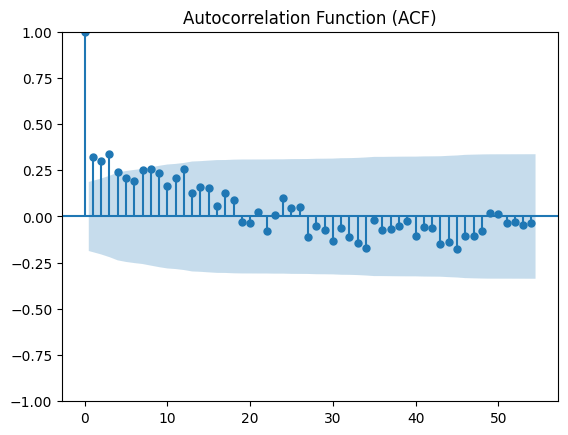

<Figure size 1200x600 with 0 Axes>

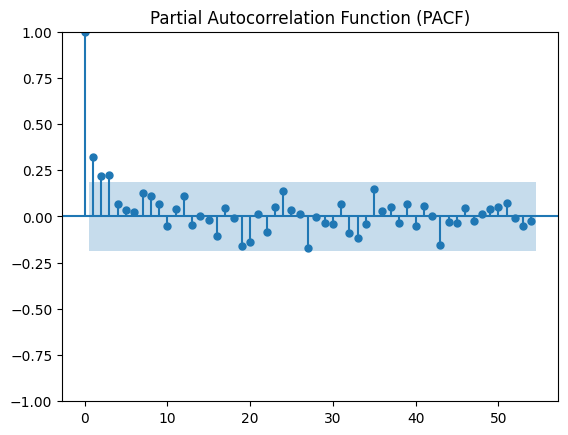


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -793.432
Date:                Mon, 17 Mar 2025   AIC                           1596.864
Time:                        15:48:44   BIC                           1610.367
Sample:                             0   HQIC                          1602.341
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2009.8747     82.488     24.366      0.000    1848.202    2171.548
ar.L1          0.2018      0.07

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for સફરજન saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_af53e0d54a1037dd6713b287013502b8.pkl
સીતાફળ size:  55
True
Checking stationarity for the raw price data of સીતાફળ:

ADF Test Results:
ADF Statistic: -6.5583
p-value: 0.0000
Critical Value 1%: -3.5577
Critical Value 5%: -2.9168
Critical Value 10%: -2.5962
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.5583
p-value: 0.0000
Critical Value 1%: -3.5577
Critical Value 5%: -2.9168
Critical Value 10%: -2.5962
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 2 at lags [ 7 10]
Significant spikes in PACF (p): 3 at lags [ 7 10 15]


<Figure size 1200x600 with 0 Axes>

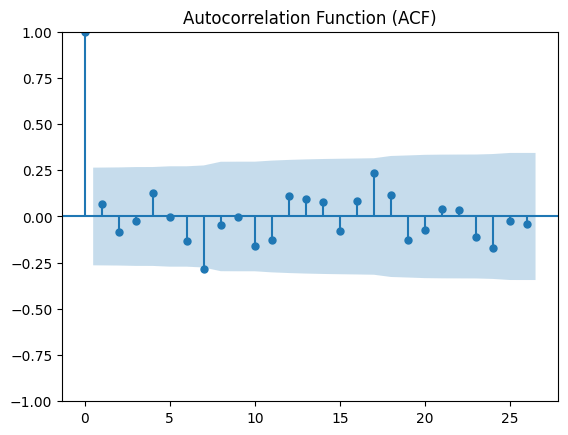

<Figure size 1200x600 with 0 Axes>

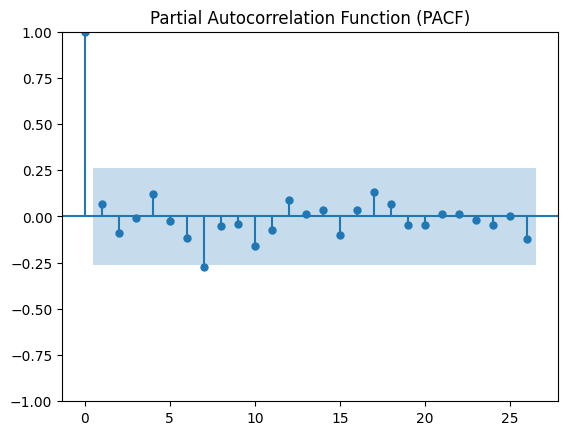


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   55
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -341.778
Date:                Mon, 17 Mar 2025   AIC                            697.556
Time:                        15:48:46   BIC                            711.608
Sample:                             0   HQIC                           702.990
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        798.3408     19.200     41.580      0.000     760.709     835.972
ar.L1          0.2270      0.265      0.857      0.391      -0.292       0.7

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

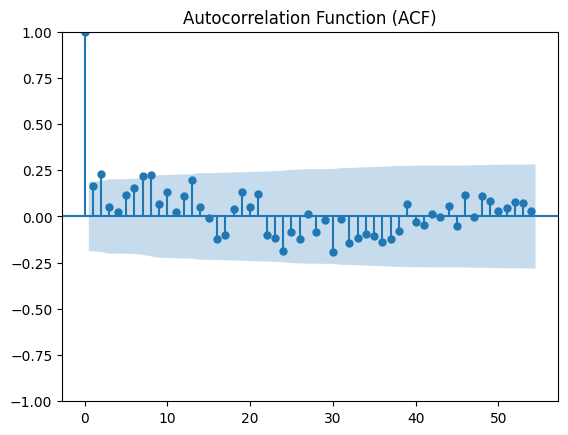

<Figure size 1200x600 with 0 Axes>

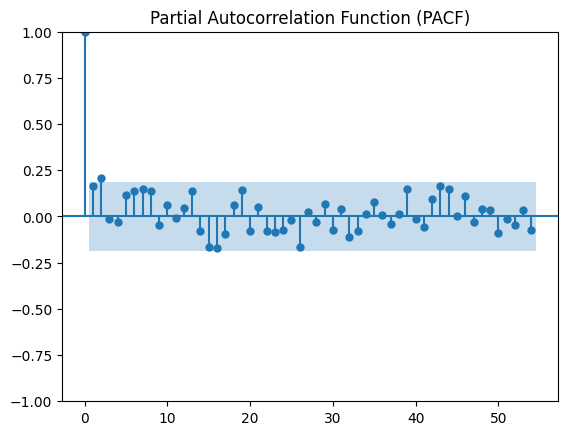


Fitting ARIMA model with order (3, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -510.043
Date:                Mon, 17 Mar 2025   AIC                           1032.087
Time:                        15:48:47   BIC                           1048.290
Sample:                             0   HQIC                          1038.659
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.3891      3.954    125.792      0.000     489.639     505.139
ar.L1          0.2273      4.916      0.046      0.963      -9.409       9.8

<Figure size 1200x600 with 0 Axes>

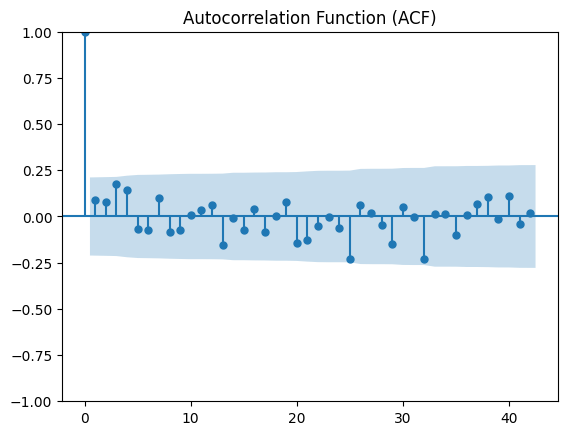

<Figure size 1200x600 with 0 Axes>

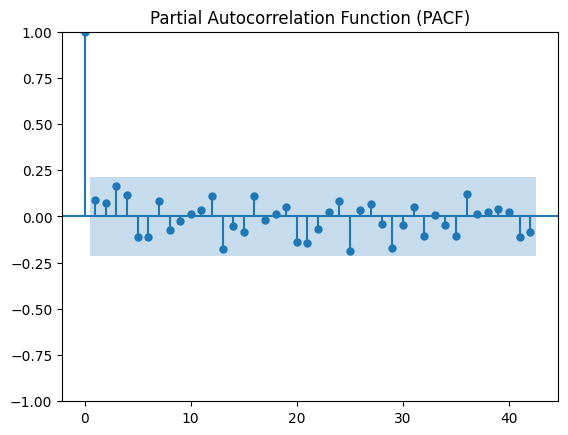


Fitting ARIMA model with order (3, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   86
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -677.562
Date:                Mon, 17 Mar 2025   AIC                           1367.124
Time:                        15:48:48   BIC                           1381.850
Sample:                             0   HQIC                          1373.050
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1098.5472    129.978      8.452      0.000     843.796    1353.299
ar.L1          0.4065      1.014      0.401      0.689      -1.582       2.3

<Figure size 1200x600 with 0 Axes>

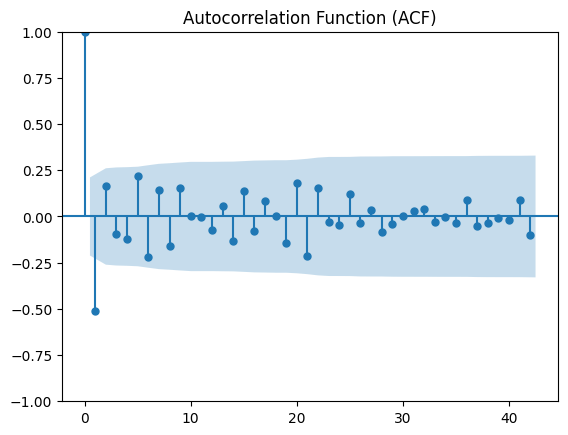

<Figure size 1200x600 with 0 Axes>

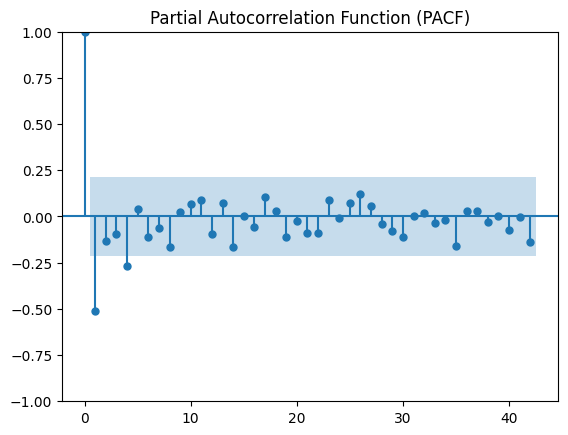


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   87
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -637.200
Date:                Mon, 17 Mar 2025   AIC                           1288.401
Time:                        15:48:49   BIC                           1305.581
Sample:                             0   HQIC                          1295.315
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1114      0.556     -2.001      0.045      -2.200      -0.023
ar.L2          0.0973      0.728      0.134      0.894      -1.330       1.5

<Figure size 1200x600 with 0 Axes>

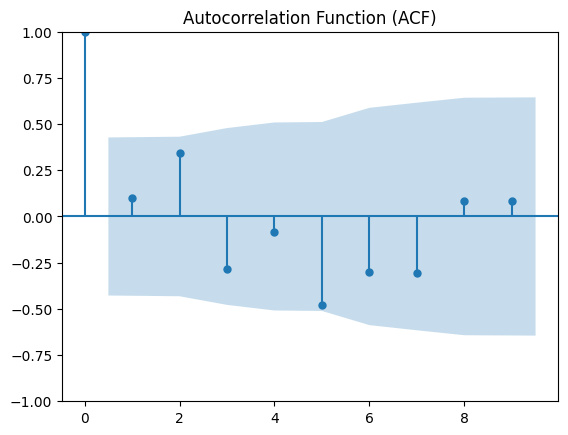

<Figure size 1200x600 with 0 Axes>

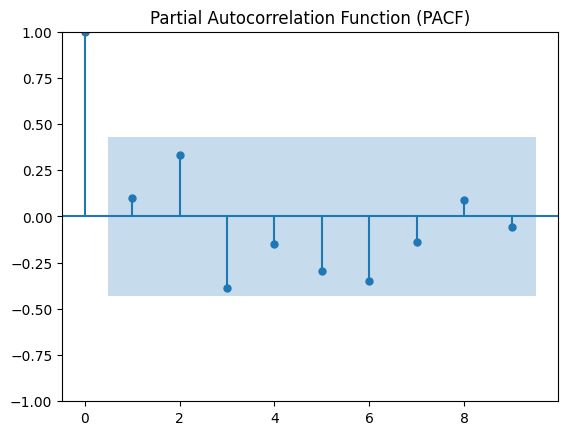


Fitting ARIMA model with order (3, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   21
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -81.715
Date:                Mon, 17 Mar 2025   AIC                            179.430
Time:                        15:48:51   BIC                            187.786
Sample:                             0   HQIC                           181.243
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3169.9964   2.37e-10   1.34e+13      0.000    3169.996    3169.996
ar.L1          0.9950    4.1e-06   2.43e+05      0.000       0.995       0.9

<Figure size 1200x600 with 0 Axes>

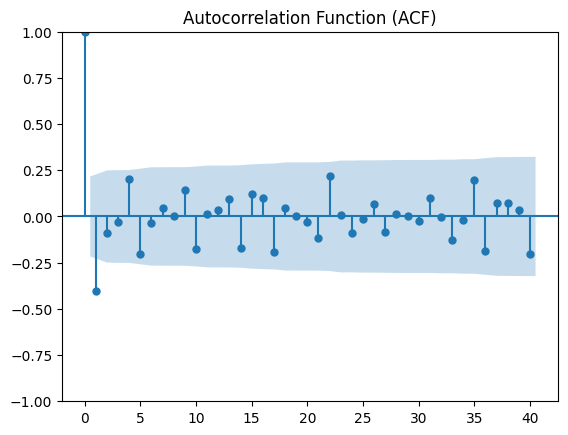

<Figure size 1200x600 with 0 Axes>

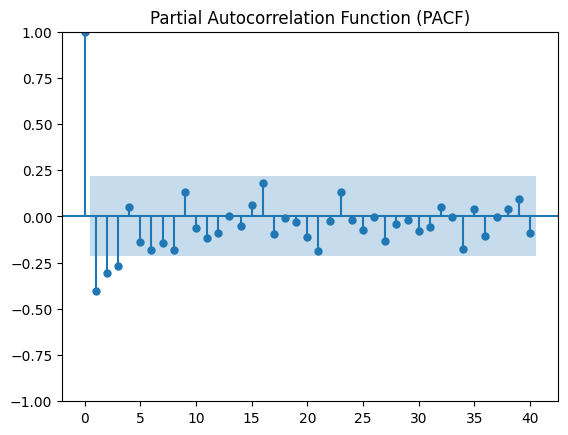


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -500.986
Date:                Mon, 17 Mar 2025   AIC                           1023.972
Time:                        15:48:53   BIC                           1050.446
Sample:                             0   HQIC                          1034.601
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4859      0.215     -2.265      0.024      -0.906      -0.065
ar.L2         -1.1947      0.251     -4.762      0.000      -1.686      -0.7

<Figure size 1200x600 with 0 Axes>

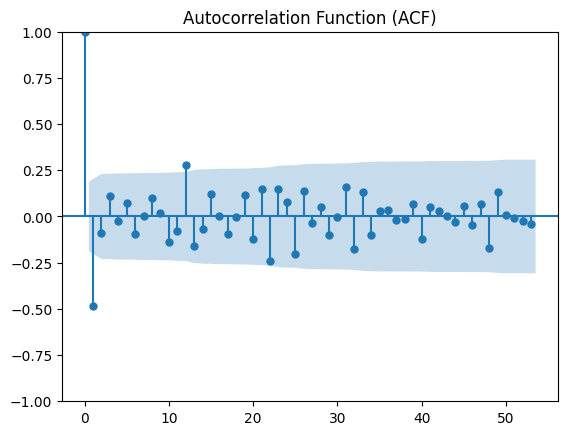

<Figure size 1200x600 with 0 Axes>

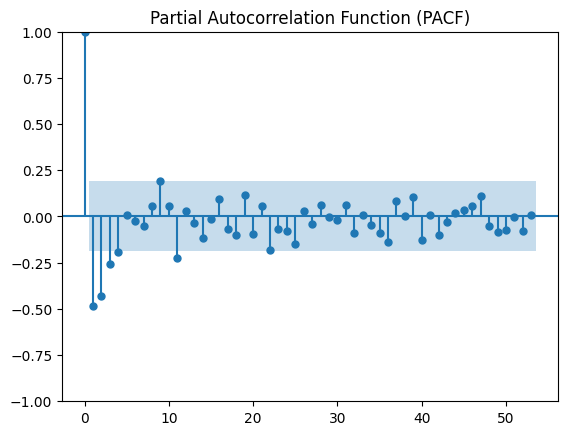


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  108
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -631.853
Date:                Mon, 17 Mar 2025   AIC                           1277.706
Time:                        15:48:55   BIC                           1296.415
Sample:                             0   HQIC                          1285.290
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3838      4.661     -0.082      0.934      -9.519       8.751
ar.L2          0.1640      1.895      0.087      0.931      -3.549       3.8

<Figure size 1200x600 with 0 Axes>

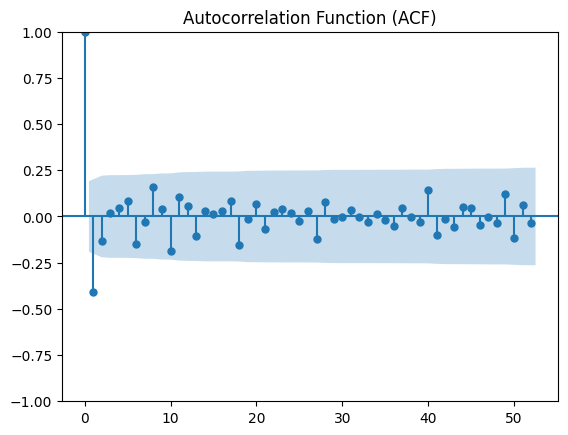

<Figure size 1200x600 with 0 Axes>

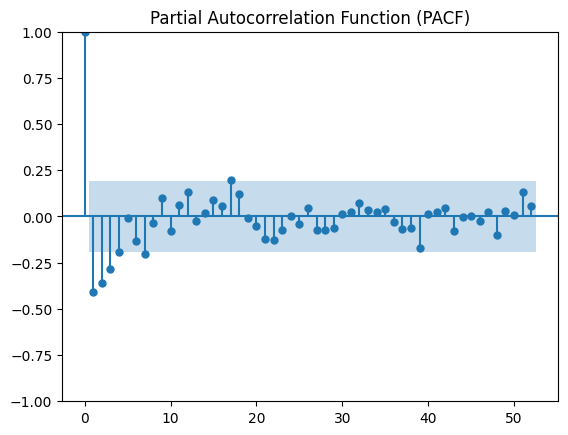


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  106
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -853.657
Date:                Mon, 17 Mar 2025   AIC                           1729.315
Time:                        15:48:57   BIC                           1758.508
Sample:                             0   HQIC                          1741.144
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1470      0.131      1.122      0.262      -0.110       0.404
ar.L2         -0.1964      0.122     -1.604      0.109      -0.436       0.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

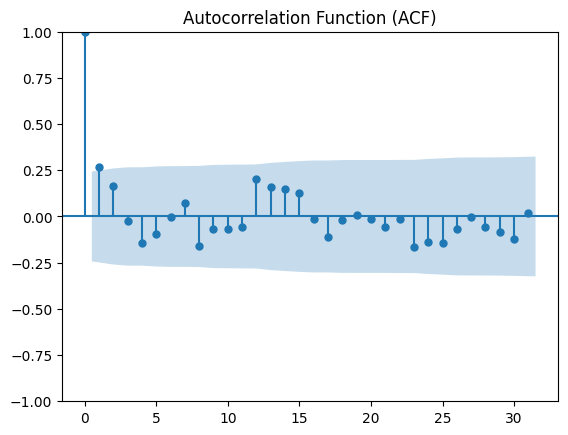

<Figure size 1200x600 with 0 Axes>

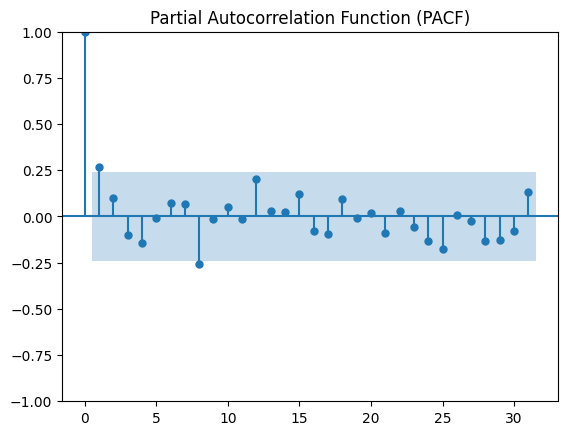


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   65
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -511.024
Date:                Mon, 17 Mar 2025   AIC                           1036.049
Time:                        15:49:00   BIC                           1051.269
Sample:                             0   HQIC                          1042.054
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5339.1026    135.495     39.404      0.000    5073.537    5604.668
ar.L1          0.4352      0.150      2.906      0.004       0.142       0.7

<Figure size 1200x600 with 0 Axes>

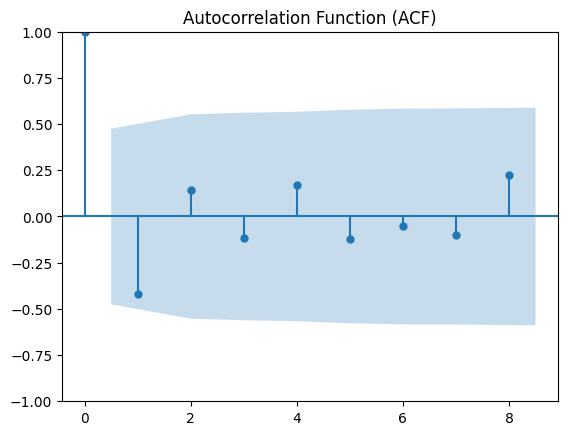

<Figure size 1200x600 with 0 Axes>

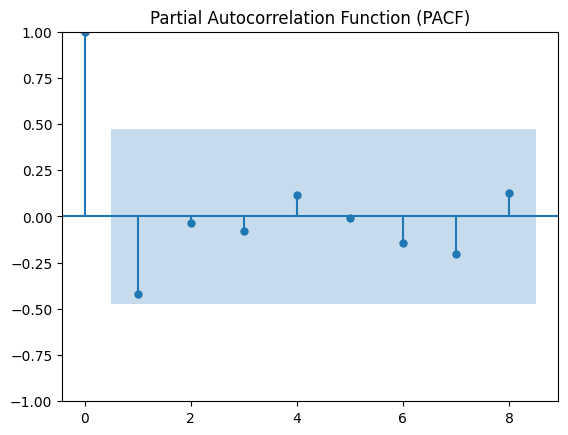


Fitting ARIMA model with order (2, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   18
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -110.843
Date:                Mon, 17 Mar 2025   AIC                            229.685
Time:                        15:49:01   BIC                            233.018
Sample:                             0   HQIC                           230.016
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1600      3.029     -0.053      0.958      -6.097       5.777
ar.L2          0.0388      1.553      0.025      0.980      -3.006       3.0

<Figure size 1200x600 with 0 Axes>

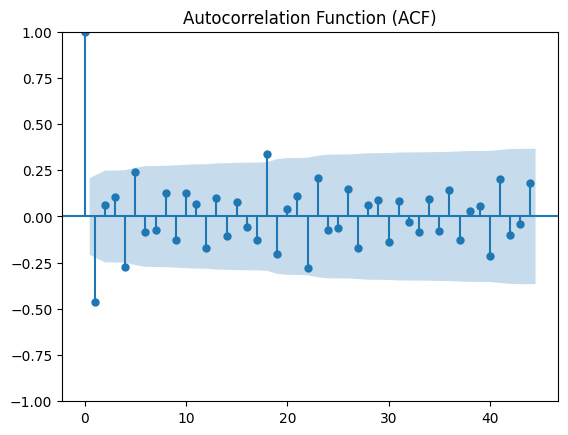

<Figure size 1200x600 with 0 Axes>

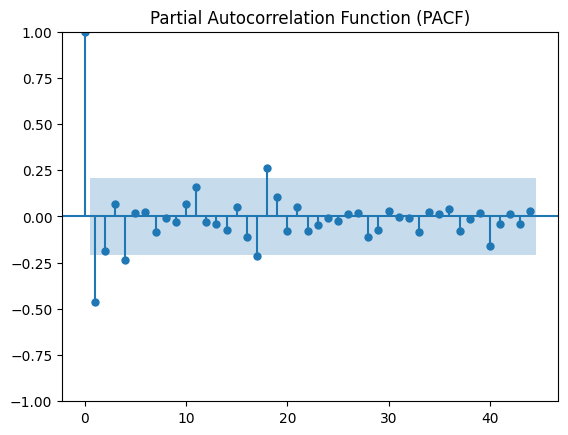


Fitting ARIMA model with order (5, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   90
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -399.998
Date:                Mon, 17 Mar 2025   AIC                            819.995
Time:                        15:49:04   BIC                            844.882
Sample:                             0   HQIC                           830.026
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3200      0.194     -1.650      0.099      -0.700       0.060
ar.L2          0.4963      0.101      4.922      0.000       0.299       0.6

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

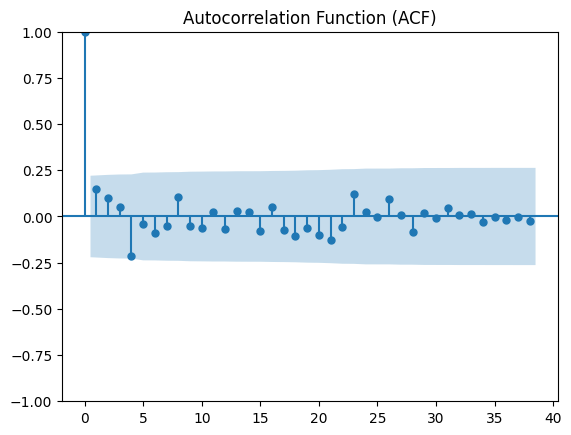

<Figure size 1200x600 with 0 Axes>

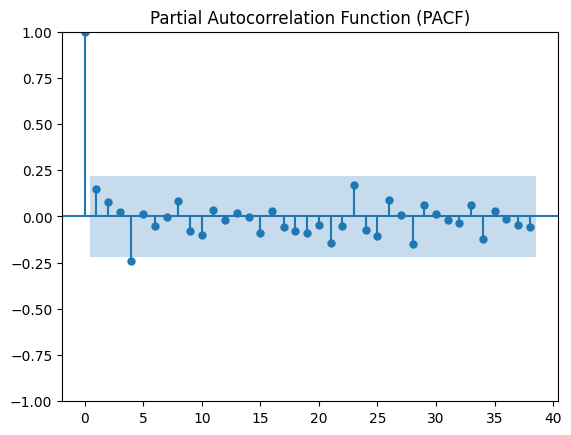


Fitting ARIMA model with order (3, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -579.499
Date:                Mon, 17 Mar 2025   AIC                           1170.999
Time:                        15:49:06   BIC                           1185.216
Sample:                             0   HQIC                          1176.695
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.9973   1028.287      1.769      0.077    -196.407    3834.402
ar.L1          0.0968      0.316      0.307      0.759      -0.522       0.7

<Figure size 1200x600 with 0 Axes>

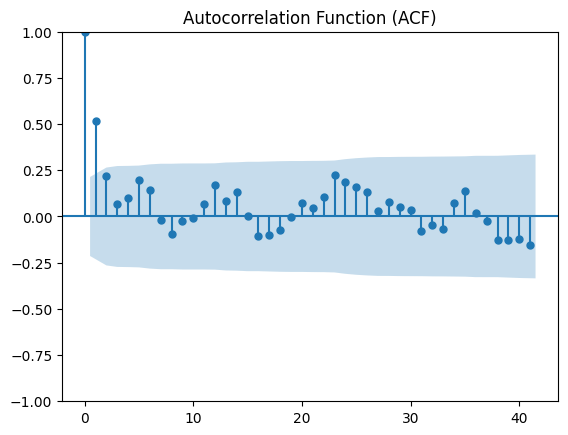

<Figure size 1200x600 with 0 Axes>

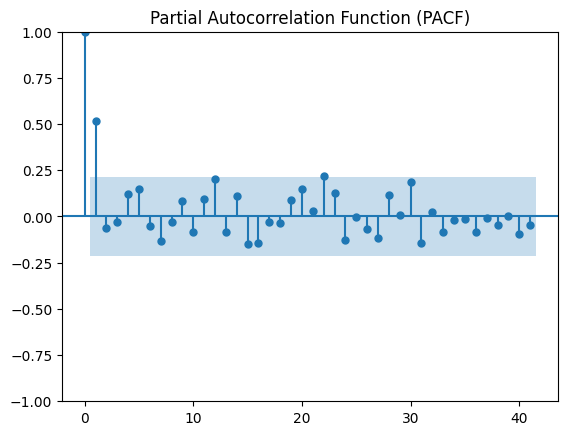


Fitting ARIMA model with order (3, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -526.187
Date:                Mon, 17 Mar 2025   AIC                           1062.374
Time:                        15:49:08   BIC                           1074.528
Sample:                             0   HQIC                          1067.259
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        721.9833     27.597     26.161      0.000     667.893     776.073
ar.L1          0.6138      0.110      5.564      0.000       0.398       0.8

<Figure size 1200x600 with 0 Axes>

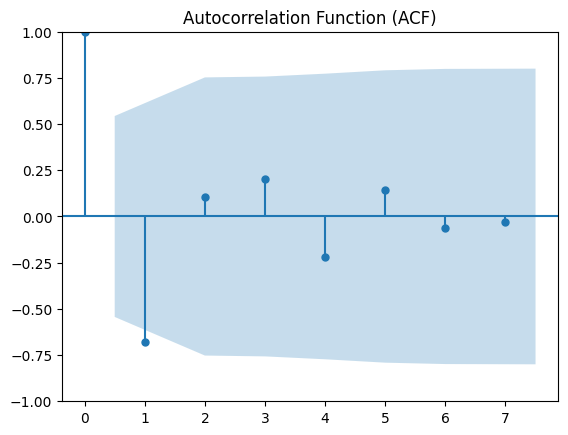

Can't plot the acf/pacf plots for અનાનસ due to Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 7 must be < 6.

Fitting ARIMA model with order (3, 3, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   16
Model:                 ARIMA(3, 3, 1)   Log Likelihood                 -84.083
Date:                Mon, 17 Mar 2025   AIC                            178.166
Time:                        15:49:09   BIC                            180.991
Sample:                             0   HQIC                           177.586
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1818      0.591     -1.998      0.046      -2.341      -0.023
ar.L2         -0.9407      0.673     -1.398      0.162      -2.260       0.3

<Figure size 1200x600 with 0 Axes>

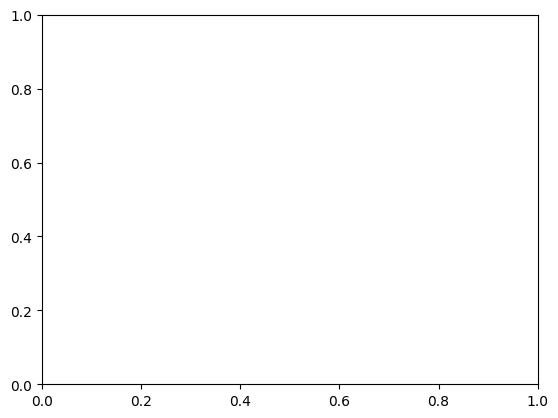

<Figure size 1200x600 with 0 Axes>

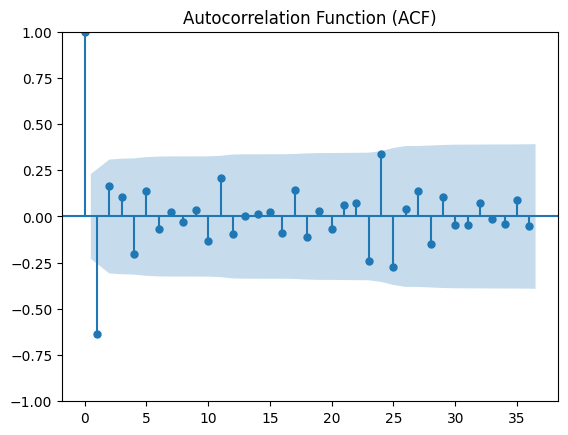

<Figure size 1200x600 with 0 Axes>

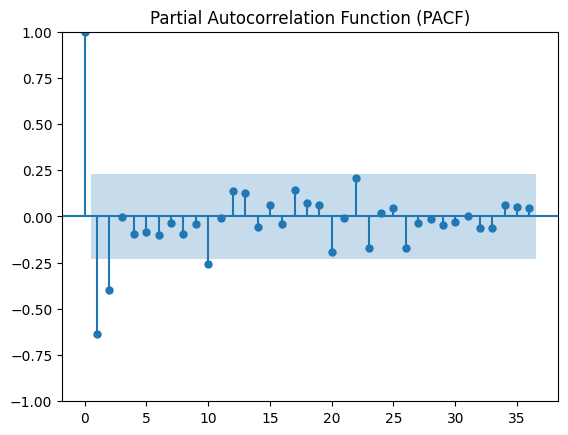


Fitting ARIMA model with order (5, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   74
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -419.832
Date:                Mon, 17 Mar 2025   AIC                            855.665
Time:                        15:49:11   BIC                            873.989
Sample:                             0   HQIC                           862.967
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6583      0.786      0.838      0.402      -0.882       2.198
ar.L2          0.3491      0.185      1.886      0.059      -0.014       0.7

<Figure size 1200x600 with 0 Axes>

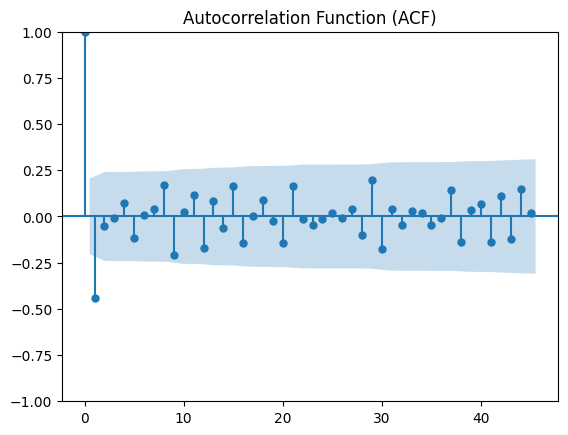

<Figure size 1200x600 with 0 Axes>

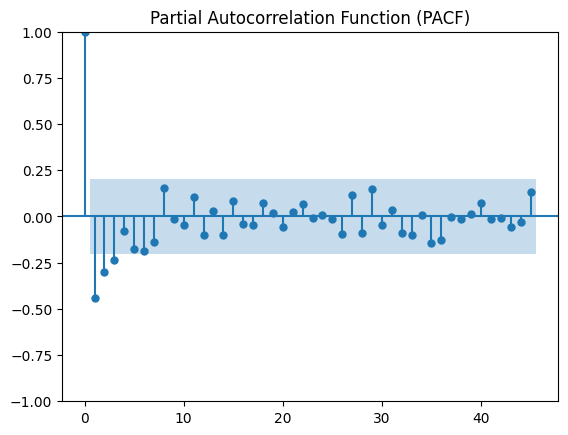


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   93
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -539.688
Date:                Mon, 17 Mar 2025   AIC                           1097.377
Time:                        15:49:13   BIC                           1120.073
Sample:                             0   HQIC                          1106.537
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7845      0.688     -1.140      0.254      -2.133       0.564
ar.L2         -0.8581      0.385     -2.226      0.026      -1.614      -0.1

<Figure size 1200x600 with 0 Axes>

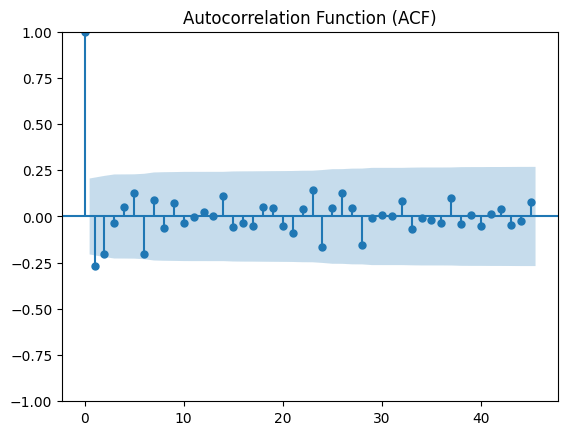

<Figure size 1200x600 with 0 Axes>

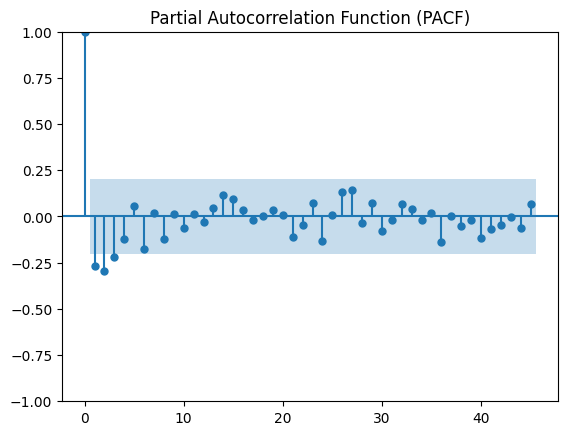


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   92
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -587.556
Date:                Mon, 17 Mar 2025   AIC                           1189.111
Time:                        15:49:15   BIC                           1206.687
Sample:                             0   HQIC                          1196.202
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0783      0.189     -5.719      0.000      -1.448      -0.709
ar.L2         -0.5837      0.275     -2.122      0.034      -1.123      -0.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

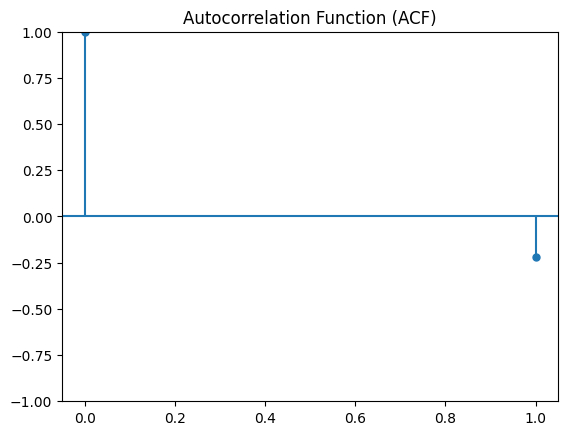

<Figure size 1200x600 with 0 Axes>

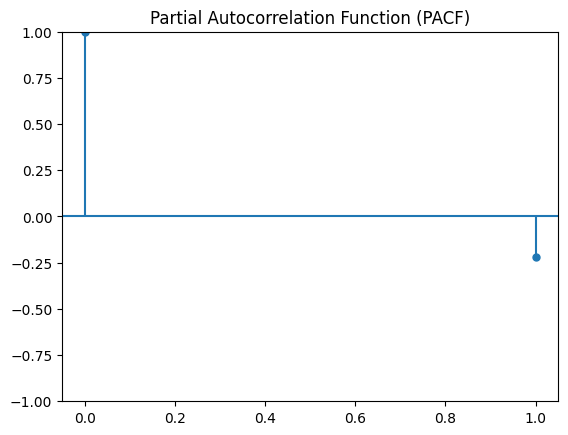


Fitting ARIMA model with order (0, 2, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    5
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 -31.462
Date:                Mon, 17 Mar 2025   AIC                             64.923
Time:                        15:49:16   BIC                             64.022
Sample:                             0   HQIC                            63.111
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.043e+07   2.52e+08      0.279      0.780   -4.24e+08    5.65e+08
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

<Figure size 1200x600 with 0 Axes>

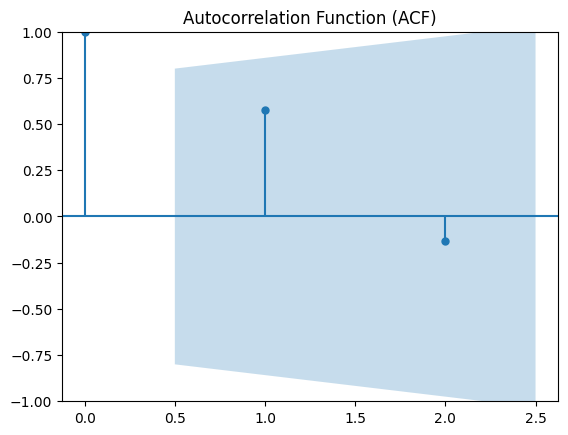

<Figure size 1200x600 with 0 Axes>

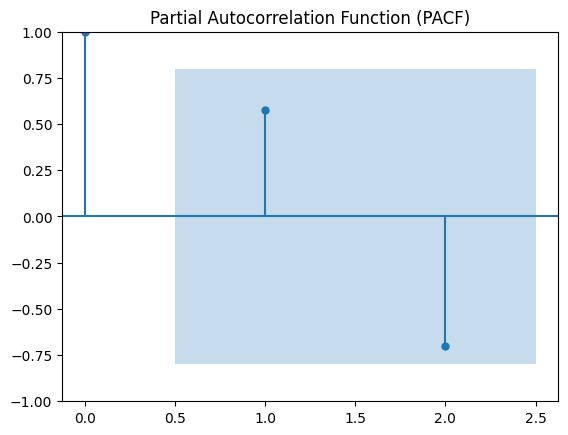


Fitting ARIMA model with order (1, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    6
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -51.127
Date:                Mon, 17 Mar 2025   AIC                            108.254
Time:                        15:49:17   BIC                            107.629
Sample:                             0   HQIC                           105.753
                                  - 6                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4763.3331   1032.259      4.614      0.000    2740.143    6786.523
ar.L1          0.6299      0.42

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

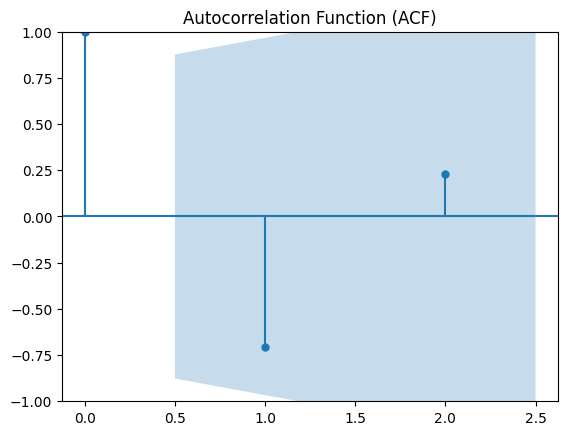

<Figure size 1200x600 with 0 Axes>

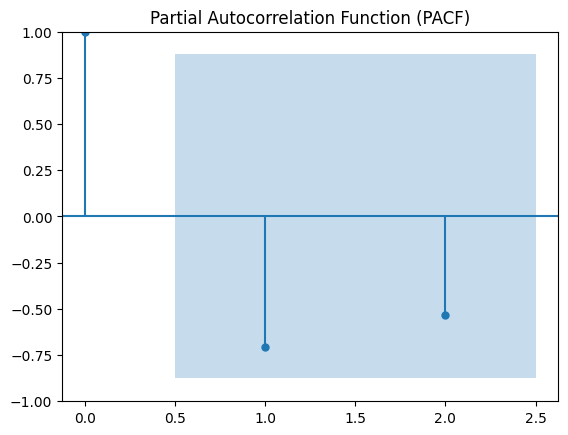


Fitting ARIMA model with order (1, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    6
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -255.658
Date:                Mon, 17 Mar 2025   AIC                            517.316
Time:                        15:49:18   BIC                            516.144
Sample:                             0   HQIC                           514.171
                                  - 6                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5353      0.007    -77.960      0.000      -0.549      -0.522
ma.L1         -0.9977      2.293     -0.435      0.663      -5.491       3.4

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/fruits/fruits_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/fruits_saved_models"
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("FRUITS_WEBPAGE_PATH"),
                                           os.getenv("FRUITS_DATE_PATH"),
                                           os.getenv("FRUITS_SUBMIT_BUTTON_PATH"),
                                           os.getenv("FRUITS_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
